In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
input_data = '/home/shpc_100839/anndata.h5ad'
adata = sc.read_h5ad(input_data)

In [3]:
adata

AnnData object with n_obs × n_vars = 452513 × 30088
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample.timepoint', 'treatment.type', 'treatment.efficacy', 'CancerType', 'Study', 'Platform', 'DateType', 'sample.ID', 'scibet.celltype', 'sample.Tissue', 'percent.mt'
    var: 'features'

In [4]:
n_hvg = 2000
n_PC = 10
n_res = 2

results_file = input_data+'.scanpy.hvg'+str(n_hvg)+'_PC'+str(n_PC)+'_res'+str(n_res)+'.h5ad' # the file that will store the analysis results
results_fig = input_data+'.scanpy.plot_hvg'+str(n_hvg)+'_PC'+str(n_PC)+'_res'+str(n_res)+'.png'

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 243 cells that have less than 200 genes expressed
filtered out 10504 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 452270 × 19584
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample.timepoint', 'treatment.type', 'treatment.efficacy', 'CancerType', 'Study', 'Platform', 'DateType', 'sample.ID', 'scibet.celltype', 'sample.Tissue', 'percent.mt', 'n_genes'
    var: 'features', 'n_cells'

normalizing counts per cell
    finished (0:00:09)


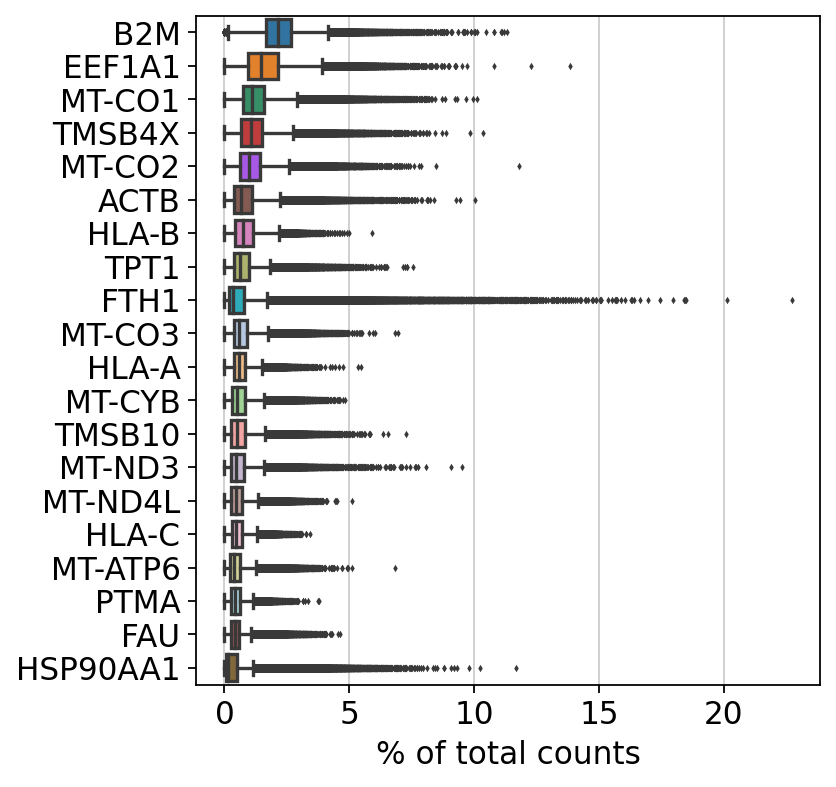

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

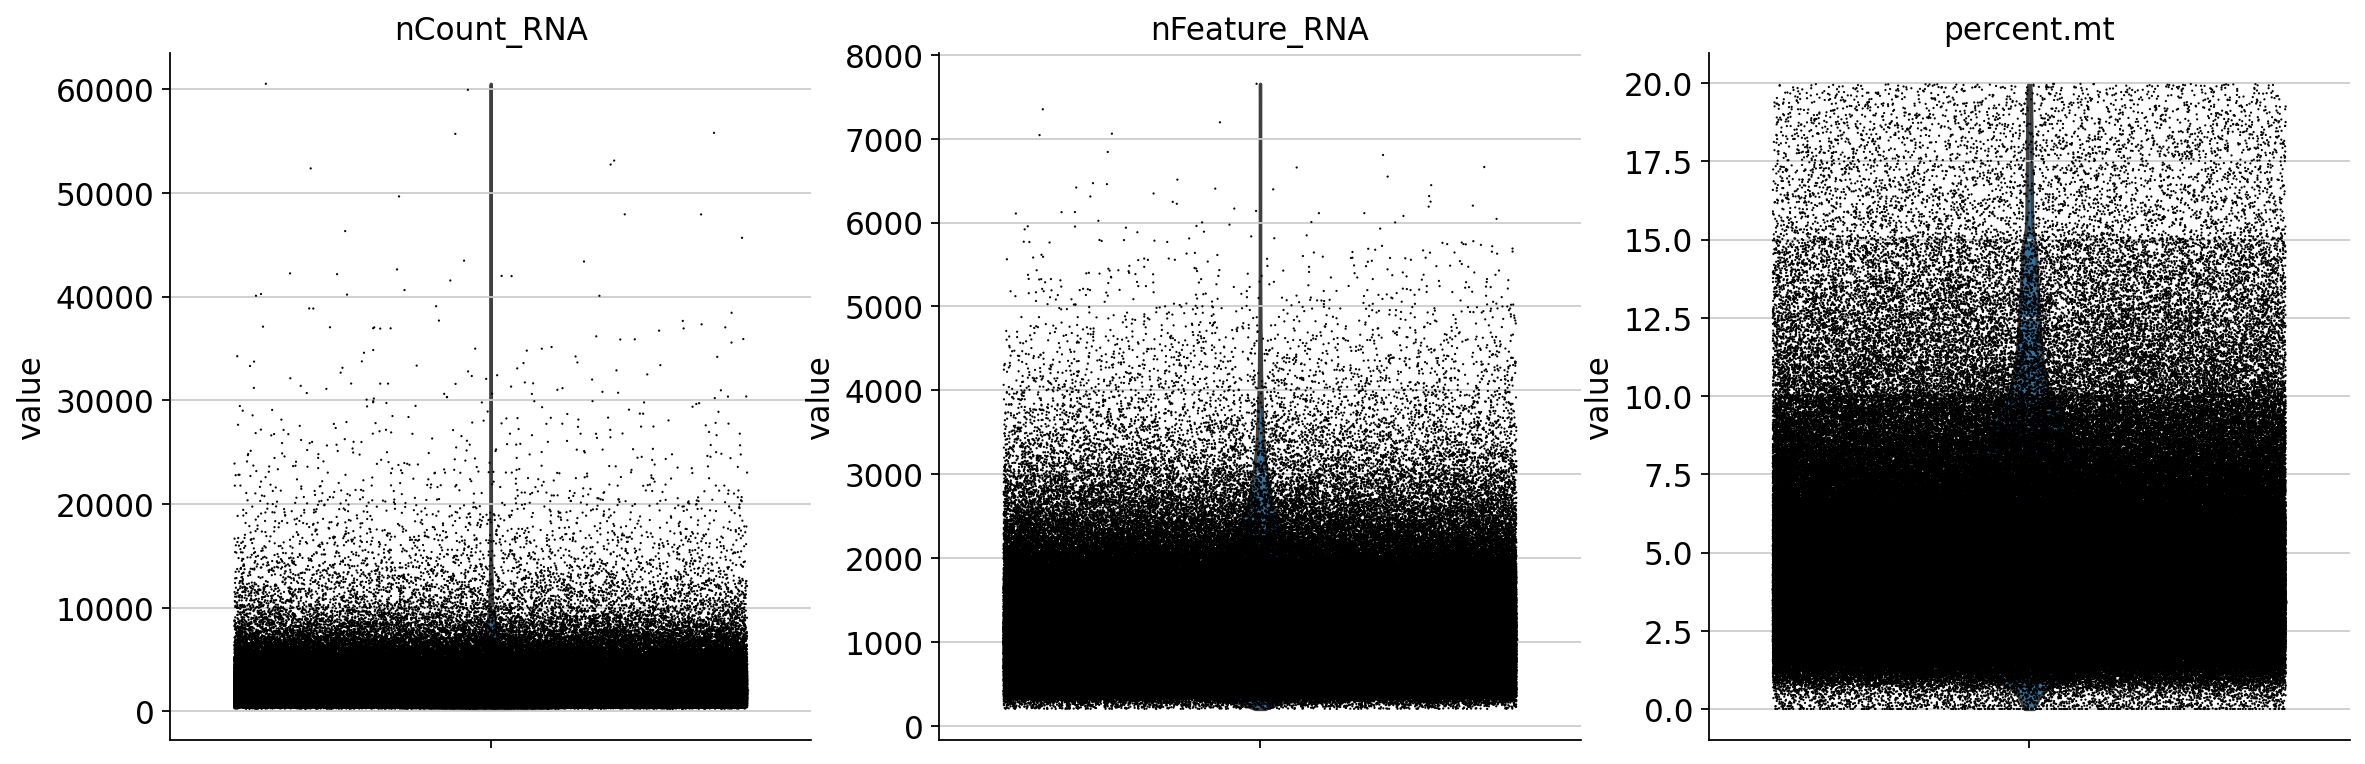

In [7]:
#sc.pl.violin(adata, ['nCount_RNA', 'nFeature_RNA', 'percent.mt'],
#             jitter=0.4, multi_panel=True)
       
# # scatter plot 
# sc.pl.scatter(adata, x='nCount_RNA', y='pct_counts_mt')
# sc.pl.scatter(adata, x='nCount_RNA', y='nFeature_RNA')
#
#
# # split adata 
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :]


In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data.
sc.pp.log1p(adata)

# identify highly-viriable genes 
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata, n_top_genes=n_hvg)

# sc.pl.highly_variable_genes(adata)

# get back an AnnData of the object in .raw by calling .raw.to_adata().
adata.raw = adata


# split hvg genes 
adata = adata[:, adata.var.highly_variable]


# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. 
# Scale the data to unit variance.
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# sc.pp.regress_out(adata, [ 'pct_counts_mt'])
sc.pp.regress_out(adata, [ 'percent.mt' ])

# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)


normalizing counts per cell
    finished (0:00:05)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:22)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['percent.mt']
    sparse input is densified and may lead to high memory use


/home/shpc_100839/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/shpc_100839/miniconda3/envs/scanpy/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/home/shpc_100839/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


    finished (1:06:59)


In [8]:
adata

AnnData object with n_obs × n_vars = 452270 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample.timepoint', 'treatment.type', 'treatment.efficacy', 'CancerType', 'Study', 'Platform', 'DateType', 'sample.ID', 'scibet.celltype', 'sample.Tissue', 'percent.mt', 'n_genes'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [9]:
sc.tl.pca(adata)

# # pca variance 
# sc.pl.pca_variance_ratio(adata, log=True)
# sc.pl.pca(adata, color='CD8A')

### Step 3: compute the neighborhood graph 
# neighbors 
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_PC)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:33)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:37)


In [10]:
sc.external.pp.bbknn(adata, batch_key='sample.ID')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:59:53)


In [11]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:48:57)


In [12]:
sc.tl.leiden(adata)
sc.tl.louvain(adata, resolution = n_res)

running Leiden clustering


In [ ]:
sc.pl.umap(adata, color=['leiden','louvain','sample.ID'], legend_loc='on data')

KeyError: 'louvain'

<Figure size 772.8x320 with 0 Axes>

In [ ]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,10)

sc.pl.umap(adata, color=['louvain','sample.ID'], legend_loc='on data')

mpl.pyplot.savefig(results_fig,dpi=300)


In [ ]:
sc.pl.umap(adata, color=['CD3D', 'CD8A', 'CD4','TRDC'])

In [ ]:
adata.write_h5ad(results_file)